In [1]:
# Start writing code here...

In [2]:
import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

from lib.viz import draw_missing_data_chart, draw_corr_heatmap, draw_components_variance_chart, biplot, draw_feature_importance

from lib.transform_impute import *
from lib.split_data import group_split, train_test_split_single_level_index
from lib.create_pipeline import create_impute_transformation_pipeline
from lib.read_data import read_feature_files, read_and_join_output_file


%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
all_features_target_df = read_and_join_output_file(start_year=2014, end_year=2021)
print(all_features_target_df.shape)

(3824, 82)


### Study the target variables

##### Shortage

In [4]:
#To  enable us to view the township and range in the hover tooltip, make a subset of the dataframe

shortage_subset_df = all_features_target_df[['SHORTAGE_COUNT', 'GSE_GWE']].copy()
shortage_subset_df = shortage_subset_df.reset_index()

 

**Observed** 

T21SR28E reports most shortage during the severe drought years of 2014 and 2015 followed by T21SR27E.



In [5]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"color":{"field":"TOWNSHIP_RANGE","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"x":{"field":"YEAR","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"y":{"field":"SHORTAGE_COUNT","scale":{"type":"linear","zero":true},"sort":null,"type":"quantitative"}},"height":220,"mark":{"tooltip":{"content":"data"},"type":"bar"}}""")

alt.Chart(...)

##### Groundwater levels

- Observed below: a dip in the groundwater levels from 2014 through 2016, the drought years, 
- then an increase until 2020 and followed by a drop in 2021, another sever drought year.

In [6]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"YEAR","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"GSE_GWE","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"TOWNSHIP_RANGE","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

### Set random state seed for consistency and reproducibility

- Use this random seed for preprocessinf 

In [7]:
RANDOM_SEED = 42

### Split the data into train and test 

-  So that we only transform the test data and there is no data leakage


We will use the years 2014-2020 as the train set and the year 2021 as the test set. There are features in the year 2021 that are missing and so we will combine the two sets to have available to us **past** years data to forward fill the features in the impute test set. The key is that we are not in the learning task here, and this holdout set is the future set, so we are not leaking information back into the past.

In [8]:
feature_columns = [col for col in all_features_target_df.columns if col not in ['TOWNSHIP_RANGE', 'YEAR', "GSE_GWE", "SHORTAGE_COUNT"]]
year_list = list(all_features_target_df.index.get_level_values('YEAR').unique())
train_year_list = year_list[0:len(year_list) - 1]
test_year_list = year_list[-1]
X_train, y_train = all_features_target_df.loc[(slice(None),train_year_list),feature_columns].copy(),all_features_target_df.loc[(slice(None),train_year_list),'GSE_GWE'].values
X_test, y_test = all_features_target_df.loc[(slice(None),test_year_list),feature_columns].copy(), all_features_target_df.loc[(slice(None),test_year_list),'GSE_GWE'].values

full_X  = X_train.append(X_test)

### Preprocessing Data


In [9]:
draw_missing_data_chart(X_train)

alt.LayerChart(...)

##### Decision on imputation to be applied to missing variables
 
We have several variables that are null as seen in the chart above.
----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Vegetation dataset**

**Cause** We do not have data for the above vegetation after 2014 for any of the TownshipRanges. That is it is absent for the years [2015, 2016, 2017, 2018, 2019, 2020, 2021]. 

**Imputation**
We will be making an assumption that the vegetation landscape of a TownshipRange does not radically differ from year to year. The vegetation values will carry over from 2014 for these vegetation types for each of the township ranges.  The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**Crops dataset** 

- For all Crops features

**Cause** We only data for 3 years over the analysis survey, 2014, 2016, 2018

**Imputation**
 We assume little year-to-year variation in crop farming and extended the data for the missing years (2015, 2017, 2019) with the data from the previous years (i.e. we assume that 2015 crops = 2014 crops). We understand that farming practices like crop rotation would challenge these assumptions. The imputation is carried out by sorting the dataframe by year and then township and then forward filling the data over to the years following.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Soils dataset**

**Cause**  We have data for soils for 2016 and not for other years. 

**Imputation**
We will be making an assumption that the basic nature of the soil of a TownshipRange does not radically differ from year to year. As we do not expect the soil type to change from year, the 2016 soil data are used for all the other years. The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**WELL COMPLETION**

**Cause** Absence of well completion reports filed in township range in certain, or all years causes values to be null

**Imputation**

We impute the GROUNDSURFACEELEVATION_AVG for a TownshipRange as the mean of the values over all years for that TownshipRange. This value that is stored in the data is the average of the elevation of the ground where wells were constructed in that TownshipRange and hence elevation was known. 

But this does not cover all the NaNs since 76 TRs do not have any value at all and  they should be filled with the average elevation of the entire area?

For the other variables since they are the **average** of the well yield, static water level, top of perforated interval, bottom of perforated interval and total completed depth of the wells constructed in each TownshipRange and so if there are **no wells newly constructed**, in a township range in a certain year, **this value will be set to 0** as these variables are well specific measurements. 


----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**RESERVOIR**

**Cause** Reservoir data is available from the California reporting stations from 2018, we are missing the data from 2014 through 2017.  

**Imputation**
Since in these years, California was stricken with drought, we will impute the values to be the **minimum** of the PCT_OF_CAPACITY for that TownshipRange.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**POPULATION**

**Cause** Population density is missing for the final year of 2021 for all townships.

**Imputation**
We will be using the previous years(2020's) trend over the year 2019 and add to the previous years (2020) value for each TownshipRanges  for the missing values in year 2021.






____________________________________________________________________________________________________
____________________________________________________________________________________________________


**NOTE**:
[Reference article](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a)
>Pipeline steps are executed serially, where the output from the first step is passed to the second step, and so on.
> ColumnTransformers are different in that each step is executed separately, and the transformed features are concatenated at the end.
>By default, any columns you pass into the ColumnTransformer that aren’t specified to be transformed will be dropped (remainder='drop'). If you have columns that you want to include but do not need to be transformed, specify remainder='passthrough'.


#### Transformation

- FunctionTransformers : enable working with a set of columns and applying transormation particular to them
- Extending the base estimator class : extends the fit and transform functionality of the BaseEstimator and transformer class

### Impute missing Data and Scale numeric data

In [10]:
impute_pipe = create_impute_transformation_pipeline(X_train)
X_train_impute = impute_pipe.fit_transform(X_train)

In [11]:
set_config(display="diagram")
display(impute_pipe)

ColumnTransformer(remainder='passthrough',
                  transformers=[('wcr',
                                 Pipeline(steps=[('imputer',
                                                  PandasSimpleImputer(fill_value=0,
                                                                      strategy='constant'))]),
                                 ['TOTALDRILLDEPTH_AVG', 'WELLYIELD_AVG',
                                  'STATICWATERLEVEL_AVG',
                                  'TOPOFPERFORATEDINTERVAL_AVG',
                                  'BOTTOMOFPERFORATEDINTERVAL_AVG',
                                  'TOTALCOMPLETEDDEPTH_AVG']),
                                ('veg',
                                 FunctionTransformer(func=<function fill_from...
                                 ['POPULATION_DENSITY']),
                                ('pct_capacity',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(aggregation_func='min',
                                                               group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='PCT_OF_CAPACITY'))]),
                                 ['PCT_OF_CAPACITY']),
                                ('gse',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='GROUNDSURFACEELEVATION_AVG'))]),
                                 ['GROUNDSURFACEELEVATION_AVG'])])

### Convert the numpy array to dataframe to view the columns imputation results

In [12]:
X_train_impute_df = convert_back_df(
    X_train_impute,
    impute_pipe,
    X_train,
)
draw_missing_data_chart(X_train_impute_df)

alt.LayerChart(...)

In [13]:
X_test_impute = impute_pipe.transform(full_X)

In [14]:

full_impute_df = convert_back_df(
    X_test_impute,
    impute_pipe,
    full_X
)
X_test_impute_df = full_impute_df.loc[(slice(None),test_year_list),:].copy()

draw_missing_data_chart(X_test_impute_df)

alt.LayerChart(...)

### Stritly adhering to the split of train and test split to scale features. 
- We do not need to scale vegetation,soil and crops
- The rest of the features do need to be scaled

- We now start with the imouted dataframe X_train_impute_df and X_test_impute_df

In [16]:
cols_to_scale = [col for col in X_train_impute_df.columns if not col.startswith(('VEGETATION_', 'SOIL_', 'CROP_'))]

scale_column_transformer = ColumnTransformer([
        ('scl', StandardScaler(), cols_to_scale)
    ], remainder='passthrough')

X_train_scale = scale_column_transformer.fit_transform(X_train_impute_df)
X_test_scale = scale_column_transformer.transform(X_test_impute_df)

In [17]:
X_train_scale_df = convert_back_df(
    X_train_scale,
    scale_column_transformer,
    X_train_impute_df,
)



### Find feature correlation 

In [18]:
draw_corr_heatmap(X_train_scale_df.reset_index(), ['TOWNSHIP_RANGE', 'YEAR'])

alt.Chart(...)

#### Co-related features observations

Well construction specific correlations that can be considered as expected since each value describes the well's dimensions and capacity

- We are considereing features with absolute value of 0.7 as being highly correlated
- Scrolling to the right of the heatmap, we see TOPOFPERFORATEDINTERVAL and BOTTOMOFPERFORATEDINTERVAL highly correlated
- BOTTOMOFPERFORATEDINTERVAL and TOPOFPERFORATEDINTERVAL are heavily correlated with TOTALCOMPLETEDDEPTH
- TOTALCOMPLETEDDEPTH is correlated with STATICWATERLEVEL

**Well Count**

- This feature was further categorized as Domestic, Agriculture and Public and hence is highly correlated to the categories (WELL_COUNT --> (WELL_COUNT_DOMESTIC, WELL_COUNT_AGRICULTURE))

**Crops**

We observe some few other correlations between
* some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is *peaches/nectarines*
* or between some crops and soils (e.g. 0.61 between `CROP_T31` *potatoes and sweet potatoes* and `SOIL_ENTISOLS_A` soil of hydrographic group *A* corresponding to coarse texture soils with high saturated hydraulic conductivity. This correlation also makes sense since potatoes tend to not grow well in soils retaining too much water.

**Vegetation**

We also see some level of correlation between the different type of forest vegetation. For example `VEGETATION_CANYON_LIVE_OAK`, `VEGETATION_HARD` and `VEGETATION_KNOBCONE_PINE` show correlation values between 0.46 and 0.6. This might be explained by the fact that some type of vegetation tend to live together.




### Dimensionality reduction for multiple vegetation, crops and soil

##### TBD

-PCA Heatmap

-Scree Plot explained_variance_ratios!!

-KMeans clustering, incorporating the clusters into the data and then running regression

- RandomForestRegressor and Feature Importance


In [19]:
pca = PCA(n_components = 3, random_state=RANDOM_SEED).fit(X_train_scale_df)

# How many features will it take to explain 95% of the variance
pca = PCA()
X_pca = pca.fit_transform(X_train_scale_df)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_95 = X_train_scale_df.shape[1] - n_over_95 + 1
print(f"Number features: {n_to_reach_95}\tTotal Variance Explained: {total_explained_variance[n_to_reach_95-1]}")

Number features: 12	Total Variance Explained: 0.9261825650779221


In [20]:
draw_components_variance_chart(pca)

alt.Chart(...)

#### Biplot to visualize PCA orientations and scores 

<module 'matplotlib.pyplot' from '/root/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

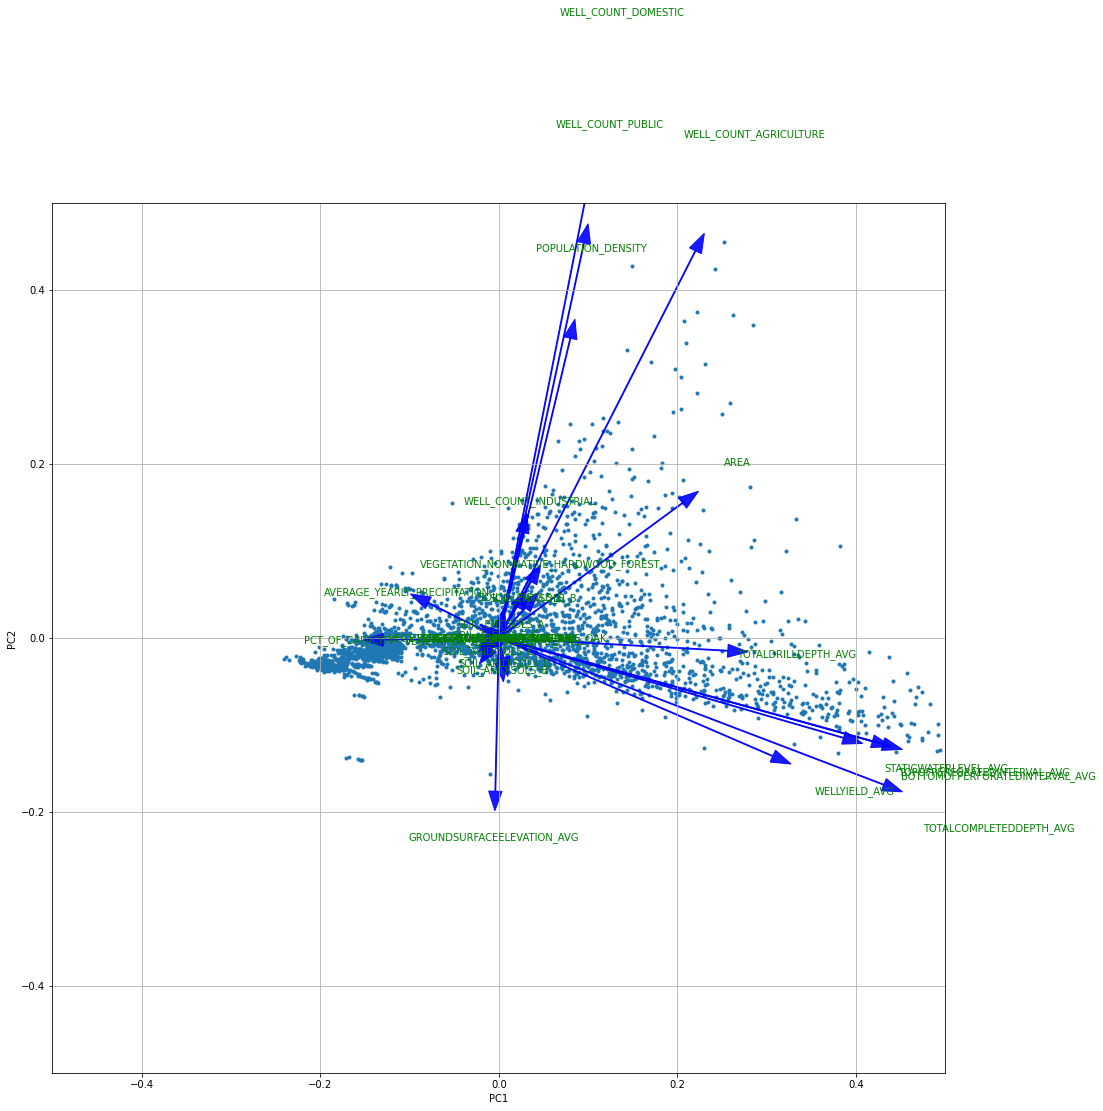

In [21]:
feature_subset_count = 30
feature_names=list(X_train_scale_df.columns)
feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

   

### Create Dummy regressors and fit on data for baseline

- This can be [scikit-learn dummy regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)
- It can be a [k-neighbors regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) 

- Create clusters K-Neighbors, Add the column with clusters to the dataset Run regression on it (say RandomForestRegressor)

###  Generative versus Declarative algorithms

###  Feature Importance

In [22]:
from sklearn.ensemble import RandomForestRegressor
col_list = [ col for col in X_train_impute_df if "TOWNSHIP_RANGE" not in col  and 'YEAR' not in col]
rfreg = RandomForestRegressor().fit(X_train_impute_df[col_list], y_train)

In [23]:
draw_feature_importance(col_list, rfreg.feature_importances_)



alt.Chart(...)

###  Analyze Shapley Feature Importance

### Unsupervised learning

- Data reduction :
    -  Creates a new nominal level variable that can be used in any further analysis
    - In one-dimension, a good way to quantize real-valued variables into k non-uniform buckets
    - More generally, can be used to compress or summarize large datasets (by replacing data points with their cluster centroids)

- Data Smoothing
   - Infer missing attributes from cluster neighborhoods

- Data understanding
    - Finding underlying factors, groups, structure

- Data navigation
    - Web search and browsing 


### STEPS
Choose an appropriate data representation (PCA)
Select a Distance measure
Select a clustering algorithm
Choose the number of clusters
Interpret the resulting clusters
Assess the quality and validity of clusters 

Iterate aftee the Assessing stage

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>